<a href="https://colab.research.google.com/github/leo0622nycu/Essay/blob/main/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
drive.mount('/content/drive')

ARIMA_OUTPUT = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_OUTPUT.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ARIMA_OUTPUT['time'] = pd.to_datetime(ARIMA_OUTPUT['time'], format='%Y-%m-%d')
ARIMA_OUTPUT.set_index('time', inplace=True)
print(ARIMA_OUTPUT)

             revenue  predicted_mean   diff_1     residuals
time                                                       
2014-01-01   51430.0    30185.751353   1749.0  21244.248647
2014-02-01   46829.0    37736.236749  -4601.0   9092.763251
2014-03-01   49956.0    64449.814235   3127.0 -14493.814235
2014-04-01   61887.0    48770.798303  11931.0  13116.201697
2014-05-01   60789.0    46333.241718  -1098.0  14455.758282
...              ...             ...      ...           ...
2024-07-01  256953.0   233264.872884  49084.0  -5053.962212
2024-08-01  250866.0   230188.241330  -6087.0  -8309.454405
2024-09-01  251873.0   238161.430872   1007.0     36.413980
2024-10-01  314240.0   271027.036806  62367.0    894.060159
2024-11-01  276058.0   285021.896380 -38182.0  13413.403211

[131 rows x 4 columns]


In [3]:
# Initialize features and targets
X_grouped = []
Y_grouped = []

# Construct features and targets
for i in range(2, len(ARIMA_OUTPUT)):
    # Lagged diff_1 and residuals (2 lags)
    x_diff_1 = ARIMA_OUTPUT['diff_1'].iloc[i-1:i].values.tolist()
    x_residuals = ARIMA_OUTPUT['residuals'].iloc[i-2:i].values.tolist()
    x_predicted_mean = ARIMA_OUTPUT['predicted_mean'].iloc[i-2:i].values.tolist()

    # Next predicted_mean value (from index i)
    #x_predicted_mean = [ARIMA_OUTPUT['predicted_mean'].iloc[i]]

    # Organize into grouped structure
    x_grouped = {
        'diff_1': x_diff_1,
        'residuals': x_residuals,
        'predicted_mean': x_predicted_mean,
    }
    X_grouped.append(x_grouped)

    # Next revenue value (from index i)
    y_value = ARIMA_OUTPUT['revenue'].iloc[i]
    Y_grouped.append(y_value)

# Confirm the result
print(X_grouped)
print(Y_grouped)

[{'diff_1': [-4601.0], 'residuals': [21244.248647315548, 9092.763250921307], 'predicted_mean': [30185.75135268445, 37736.23674907869]}, {'diff_1': [3127.0], 'residuals': [9092.763250921307, -14493.814235076592], 'predicted_mean': [37736.23674907869, 64449.81423507659]}, {'diff_1': [11931.0], 'residuals': [-14493.814235076592, 13116.20169715795], 'predicted_mean': [64449.81423507659, 48770.79830284205]}, {'diff_1': [-1098.0], 'residuals': [13116.20169715795, 14455.758282181168], 'predicted_mean': [48770.79830284205, 46333.24171781883]}, {'diff_1': [-445.0], 'residuals': [14455.758282181168, -6540.562657700721], 'predicted_mean': [46333.24171781883, 66884.56265770072]}, {'diff_1': [4581.0], 'residuals': [-6540.562657700721, -2378.879003268288], 'predicted_mean': [66884.56265770072, 67303.87900326829]}, {'diff_1': [4354.0], 'residuals': [-2378.879003268288, 13353.710193225916], 'predicted_mean': [67303.87900326829, 55925.28980677408]}, {'diff_1': [5567.0], 'residuals': [13353.710193225916

In [4]:
X_flattened = []
for x_dict in X_grouped:
    # 依照順序將 diff_1, predicted_mean, residuals 三段串起來
    # 注意：x_dict['diff_1'] 是多個值 (ex: 3個 lag)，
    #       x_dict['predicted_mean'] 和 x_dict['residuals'] 各是一個或多個值
    flattened = x_dict['diff_1'] + x_dict['predicted_mean'] + x_dict['residuals']
    X_flattened.append(flattened)

In [5]:
X_array = np.array(X_flattened)
y_array = np.array(Y_grouped)
print(X_array)
print(y_array)

[[-4.60100000e+03  3.01857514e+04  3.77362367e+04  2.12442486e+04
   9.09276325e+03]
 [ 3.12700000e+03  3.77362367e+04  6.44498142e+04  9.09276325e+03
  -1.44938142e+04]
 [ 1.19310000e+04  6.44498142e+04  4.87707983e+04 -1.44938142e+04
   1.31162017e+04]
 [-1.09800000e+03  4.87707983e+04  4.63332417e+04  1.31162017e+04
   1.44557583e+04]
 [-4.45000000e+02  4.63332417e+04  6.68845627e+04  1.44557583e+04
  -6.54056266e+03]
 [ 4.58100000e+03  6.68845627e+04  6.73038790e+04 -6.54056266e+03
  -2.37887900e+03]
 [ 4.35400000e+03  6.73038790e+04  5.59252898e+04 -2.37887900e+03
   1.33537102e+04]
 [ 5.56700000e+03  5.59252898e+04  6.68016601e+04  1.33537102e+04
   8.04433991e+03]
 [ 5.89000000e+03  6.68016601e+04  7.86914572e+04  8.04433991e+03
   2.04454277e+03]
 [-8.46100000e+03  7.86914572e+04  7.69071364e+04  2.04454277e+03
  -4.63213639e+03]
 [-2.76500000e+03  7.69071364e+04  7.38697635e+04 -4.63213639e+03
  -4.35976350e+03]
 [ 1.76100000e+04  7.38697635e+04  7.39310781e+04 -4.35976350e+03

In [6]:
train_X = X_flattened[:103]
train_Y = Y_grouped[:103]

test_X =  X_flattened[103:]
test_Y = Y_grouped[103:]

print(train_X)
print(train_Y)
print(test_X)
print(test_Y)

[[-4601.0, 30185.75135268445, 37736.23674907869, 21244.248647315548, 9092.763250921307], [3127.0, 37736.23674907869, 64449.81423507659, 9092.763250921307, -14493.814235076592], [11931.0, 64449.81423507659, 48770.79830284205, -14493.814235076592, 13116.20169715795], [-1098.0, 48770.79830284205, 46333.24171781883, 13116.20169715795, 14455.758282181168], [-445.0, 46333.24171781883, 66884.56265770072, 14455.758282181168, -6540.562657700721], [4581.0, 66884.56265770072, 67303.87900326829, -6540.562657700721, -2378.879003268288], [4354.0, 67303.87900326829, 55925.28980677408, -2378.879003268288, 13353.710193225916], [5567.0, 55925.28980677408, 66801.66008777673, 13353.710193225916, 8044.339912223266], [5890.0, 66801.66008777673, 78691.45722754268, 8044.339912223266, 2044.542772457324], [-8461.0, 78691.45722754268, 76907.13639411461, 2044.542772457324, -4632.136394114612], [-2765.0, 76907.13639411461, 73869.763496147, -4632.136394114612, -4359.763496147003], [17610.0, 73869.763496147, 73931.0

In [7]:
!pip install scikit-learn==1.3.2

In [8]:

from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from re import X

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=3,
    random_state=42,
)
model.fit(train_X, train_Y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
y_pred_test = model.predict(test_X)

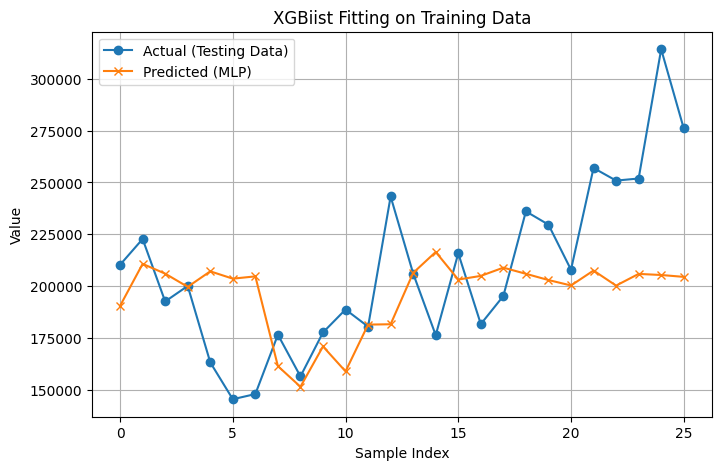

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(len(test_Y)), test_Y, marker='o', label='Actual (Testing Data)')


y_pred_test_1d = y_pred_test.flatten()
plt.plot(range(len(y_pred_test_1d)), y_pred_test_1d, marker='x', label='Predicted (MLP)')

plt.title('XGBiist Fitting on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np



# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(test_Y, y_pred_test_1d))

# 2. 計算 MAE
mae = mean_absolute_error(test_Y, y_pred_test_1d)

# 3. 計算 MAPE
mape = np.mean(np.abs((test_Y - y_pred_test_1d) / test_Y)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 40449.73
MAE : 30962.04
MAPE : 14.60%
